# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN.

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим?

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from IPython.display import clear_output


## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize([0.4914, 0.4822, 0.4465],
                                                 [0.2470, 0.2435, 0.2616])]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s]


Посмотрим на изображения:

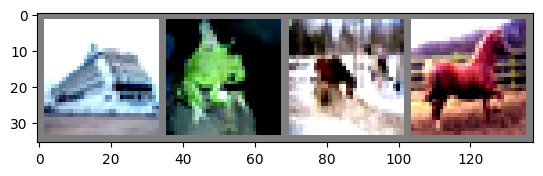

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

In [ ]:
images.shape

torch.Size([64, 3, 32, 32])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        # <your code here>
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32,
                      kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=1)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(8, 8))
        self.bn_1 = nn.BatchNorm2d(32)
        self.bn_2 = nn.BatchNorm2d(32)
        self.lin = nn.Linear(32 * 4 * 4, n_classes)
        self.flat = nn.Flatten()

    def forward(self, x):
        out = self.conv_1(x)
        out = self.bn_1(out)
        out = self.relu(out)

        residual = self.shortcut(x)

        out = self.conv_2(out)
        out = self.bn_2(out)

        out = out + residual
        out = self.relu(out)

        out = self.pool(out)
        out = self.flat(out)
        out = self.lin(out)

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
  (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=512, out_features=10, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [16]:
#https://github.com/FUlyankin/deep_learning_pytorch/blob/main/week06_conv_nets/conv_nn_solve.ipynb

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(train_losses, label='train')

    points = np.array(test_losses)
    axs[0].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(train_accuracies, label='train')
    points = np.array(test_accuracies)
    axs[1].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('step')
        ax.legend()

    plt.show()

In [13]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        # <your code here>
        with torch.no_grad():
          y_pred = model(data)
          loss = F.cross_entropy(y_pred, target)

        loss_log.append(loss.item())

        # <your code here>
        acc = (torch.argmax(y_pred, dim=-1) == target).float().mean()

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        # <your code here>
        optimizer.zero_grad()

        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        # <your code here>
        acc = (torch.argmax(y_pred, dim=-1) == target).float().mean()

        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(train_loader.dataset) / 64

        val_loss_log.append((steps * (epoch + 1), val_loss))
        val_acc_log.append((steps * (epoch + 1), val_acc))

        clear_output()
        plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.4889707544603994, train acc: 0.4702272134027708
 val loss: 1.2708655697234132, val acc: 0.5610150710065314

Epoch 1
 train loss: 1.155858727543184, train acc: 0.5998098394770509
 val loss: 1.0757725266700096, val acc: 0.6246232271194458

Epoch 2
 train loss: 1.049909408393246, train acc: 0.634826325520301
 val loss: 1.070934536355607, val acc: 0.6245567377577437

Epoch 3
 train loss: 0.9875428447775693, train acc: 0.6572008031595777
 val loss: 0.9849248330643836, val acc: 0.6583998228641267

Epoch 4
 train loss: 0.9562147924407527, train acc: 0.6662395534393338
 val loss: 1.0245310352203694, val acc: 0.6464760638297873

Epoch 5
 train loss: 0.9328390730364449, train acc: 0.6777756921334066
 val loss: 1.044921651799628, val acc: 0.6417109930768926

Epoch 6
 train loss: 0.9036835012531803, train acc: 0.6849332398426816
 val loss: 0.9281300169356326, val acc: 0.6802083335024245

Epoch 7
 train loss: 0.8818550095152812, train acc: 0.6949880844496286
 val loss: 0.9044

Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>
test_acc = test(net, test_loader)[1].mean()
test_acc

np.float64(0.6900875796178344)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

[[5.46875000e+02 1.13765613e+00]
 [1.09375000e+03 1.12392892e+00]
 [1.64062500e+03 1.00302265e+00]
 [2.18750000e+03 9.72899953e-01]
 [2.73437500e+03 9.37585104e-01]
 [3.28125000e+03 1.01340440e+00]
 [3.82812500e+03 9.46764205e-01]
 [4.37500000e+03 9.54407111e-01]
 [4.92187500e+03 9.10182628e-01]
 [5.46875000e+03 8.94291875e-01]
 [6.01562500e+03 8.92408609e-01]
 [6.56250000e+03 9.24633221e-01]
 [7.10937500e+03 9.00982590e-01]
 [7.65625000e+03 9.02007457e-01]
 [8.20312500e+03 8.70848301e-01]
 [8.75000000e+03 8.58434329e-01]
 [9.29687500e+03 8.41492753e-01]
 [9.84375000e+03 8.87486550e-01]
 [1.03906250e+04 9.02695553e-01]
 [1.09375000e+04 8.39208232e-01]]


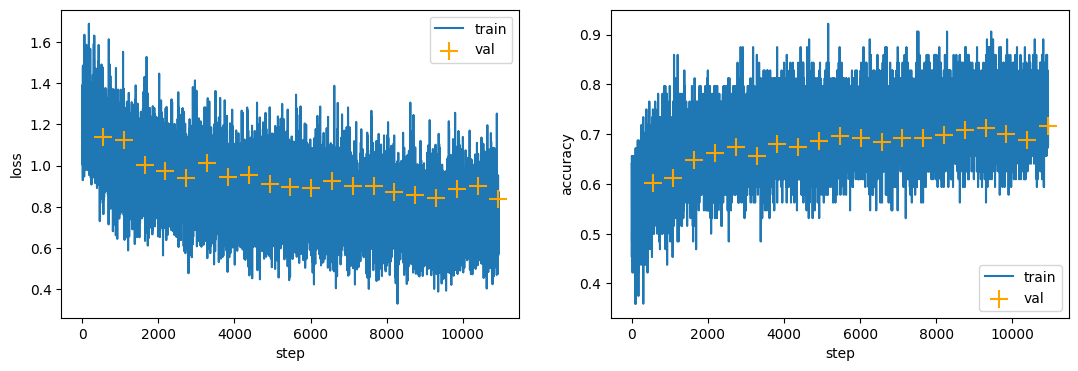

Epoch 19
 train loss: 0.737525244844461, train acc: 0.7447848655623971
 val loss: 0.8392082315810183, val acc: 0.7172207446808511



In [14]:
# <your code here>
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

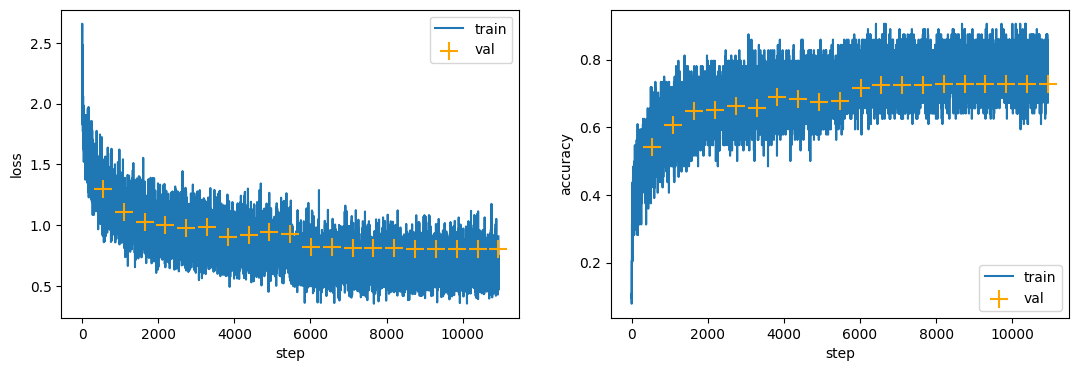

Epoch 19
 train loss: 0.6796146915643263, train acc: 0.7667920801931587
 val loss: 0.8010815330008243, val acc: 0.7285682624958931



In [17]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Посчитайте точность на тестовой выборке:

In [18]:
# <your code here>
test_acc = test(net, test_loader)[1]
test_acc

np.float64(0.7262141719745223)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

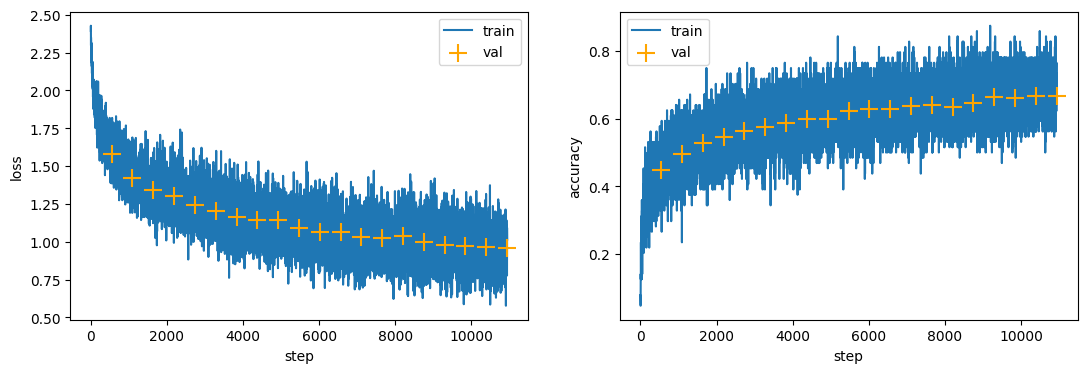

Epoch 19
 train loss: 0.9385920918837761, train acc: 0.6760169104204753
 val loss: 0.9561144286013664, val acc: 0.6658244680851064



In [19]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

In [20]:
# <your code here>
test_acc = test(net, test_loader)[1]
test_acc

np.float64(0.6642117834394905)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

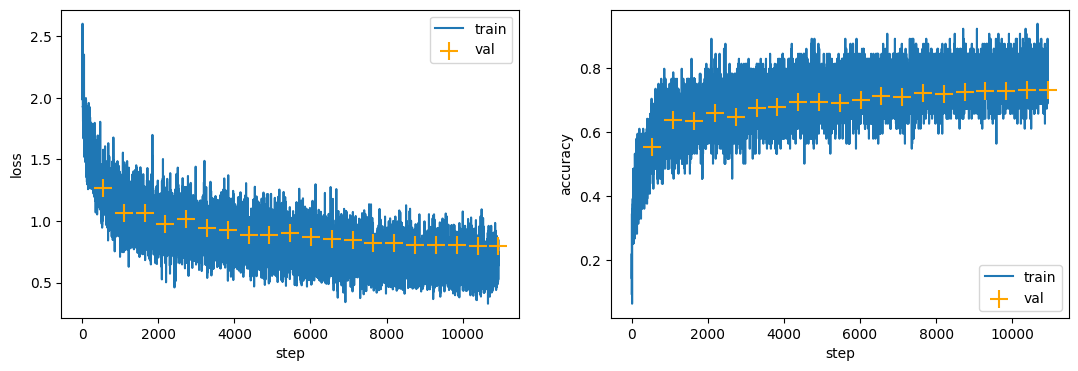

Epoch 19
 train loss: 0.6627823090422524, train acc: 0.7718031797592121
 val loss: 0.7962375105695522, val acc: 0.7308289007937655



In [21]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

In [22]:
test_acc = test(net, test_loader)[1]
test_acc

np.float64(0.716859076433121)

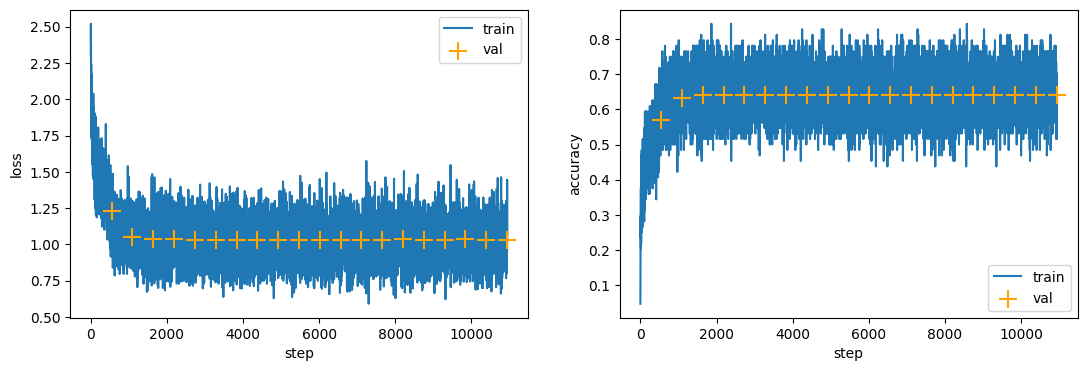

Epoch 19
 train loss: 1.010842495252271, train acc: 0.648819045458241
 val loss: 1.0335316462719695, val acc: 0.6420877659574468



In [26]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

In [27]:
test_acc = test(net, test_loader)[1]
test_acc

np.float64(0.6375398089171974)

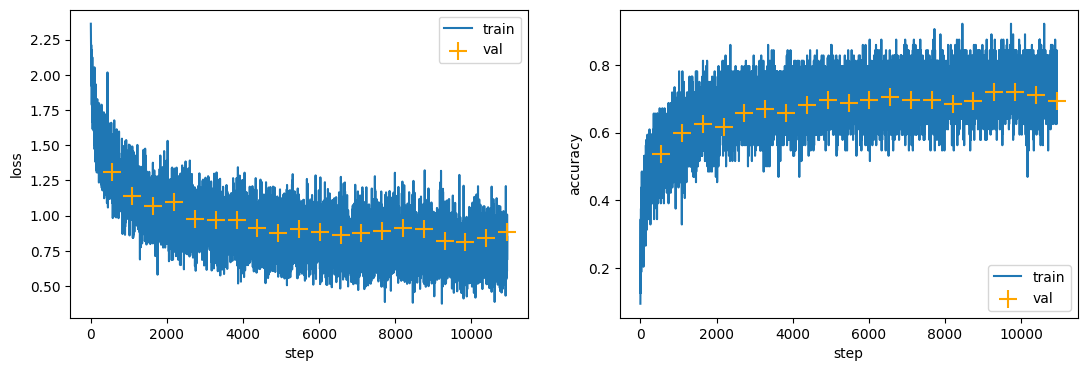

Epoch 19
 train loss: 0.7504591878088126, train acc: 0.7397492818902136
 val loss: 0.8815981317073741, val acc: 0.6943262412192973



In [28]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

In [29]:
test_acc = test(net, test_loader)[1]
test_acc

np.float64(0.6854100318471338)

Your answers here:

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

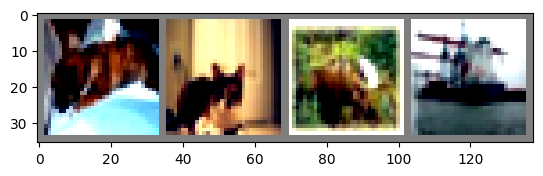

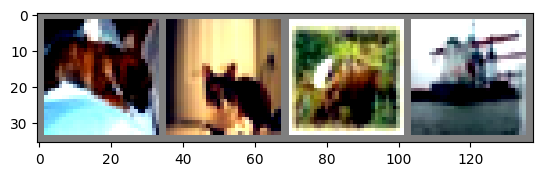

In [31]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

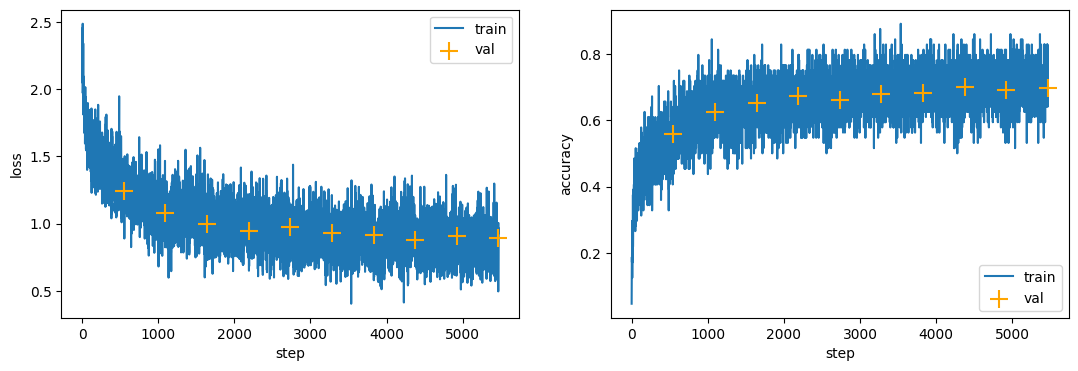

Epoch 9
 train loss: 0.8454156112627312, train acc: 0.7071077631857975
 val loss: 0.8931063931039039, val acc: 0.6973847518575952



In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>
test_acc = test(net, test_loader)[1]
test_acc

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# <your code here>


Your answers here:

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [ ]:
# <your code here>